## Сбор данных (создание веб-краулера)

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    #print(row_date)
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам (на сайте Яндекс Дзен)

In [2]:
def parse_rubrics():
    rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']
    rubrics_links = ['rubric/politics', 'rubric/society', 'rubric/business', 'rubric/world', 'rubric/sport', 'rubric/incident', 'rubric/culture', 'rubric/computers', 'rubric/science']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

#parse_rubrics()

### Сбор похожих новостей при переходе к каждой новости (на сайте Яндекс Дзен)

In [3]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

#parse_main()

### Сохранение и чтение данных в формате xlsx

In [4]:
df1 = parse_main()

# Для mac
df1.to_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df1.to_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

In [5]:
# Для mac
df2 = pd.read_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df2 = pd.read_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

# Выражение, добавляющее к БД только новые новости
res = df1[~df1['url'].isin(df2['url'])]

#res
#df1

## Разведочный анализ данных EDA

In [6]:
# Объем данных (строк и столбцов - объектов и признаков)
df1.shape

(1822, 8)

In [7]:
# Вывод типов данных
df1.dtypes

rubric         object
story_id       object
title          object
text           object
sourceName     object
instory_url    object
url            object
time           object
dtype: object

<div class="alert alert-success"><b>Целевой признак - rubric</b>

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rubric       1822 non-null   object
 1   story_id     1822 non-null   object
 2   title        1822 non-null   object
 3   text         1822 non-null   object
 4   sourceName   1822 non-null   object
 5   instory_url  1822 non-null   object
 6   url          1822 non-null   object
 7   time         1822 non-null   object
dtypes: object(8)
memory usage: 114.0+ KB


<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [9]:
# Имена колонок в виде списков
df1.columns

Index(['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url',
       'url', 'time'],
      dtype='object')

In [10]:
# Кол-во пропусков во всем датафрейме
df1.isnull().sum()

rubric         0
story_id       0
title          0
text           0
sourceName     0
instory_url    0
url            0
time           0
dtype: int64

In [11]:
# Статистика распределения этих значений в % виде
df1['rubric'].value_counts(normalize=True)

Происшествия    0.351262
Спорт           0.104281
Общество        0.096597
Политика        0.096048
В мире          0.091658
Наука           0.068606
Экономика       0.066411
Культура        0.065313
Технологии      0.059824
Name: rubric, dtype: float64

In [12]:
# Исследование целевого (target) признака - рубрики 
print('Кол-во уникальных значений: ', df1['rubric'].nunique())
print('Список уникальных значений: ', df1['rubric'].unique())
print('Статистика распределения значений: ', df1['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Происшествия    640
Спорт           190
Общество        176
Политика        175
В мире          167
Наука           125
Экономика       121
Культура        119
Технологии      109
Name: rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [13]:
# Описательная статистика для признака rubric
df1['rubric'].describe()

count             1822
unique               9
top       Происшествия
freq               640
Name: rubric, dtype: object

In [14]:
# Описательная статистика для всех признаков 
df1.describe().T

,count,unique,top,freq
rubric,1822,9,Происшествия,640
story_id,1822,248,705773078,100
title,1822,1658,Три человека погибли при взрыве бензовоза на а...,8
text,1822,1699,Чеченский оппозиционер и блогер Тумсо Абдурахм...,4
sourceName,1822,544,Газета.Ru,42
instory_url,1822,261,https://dzen.ru/news/instory/14letnyaya_devoch...,100
url,1822,1724,https://xn--80abnrcriwo.xn--p1ai/news/61874.ht...,2
time,1822,696,05.12.2022 15:06,20


### Визульный анализ

<AxesSubplot:>

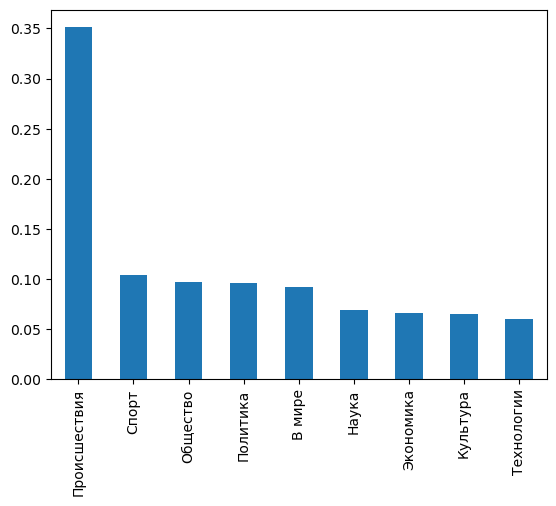

In [15]:
# Столбчатая диаграмма
# По оси y - доля в %, по x - сами рубрики
# Если поменять normalize=True на normalize=False, то ось y будет в кол-ом значении

df1['rubric'].value_counts(normalize=True).plot.bar()

<AxesSubplot:ylabel='rubric'>

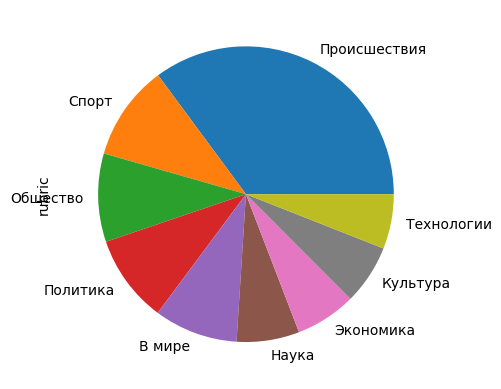

In [16]:
# Круговая(пирожковая) диаграмма
df1['rubric'].value_counts(normalize=True).plot.pie()

<AxesSubplot:>

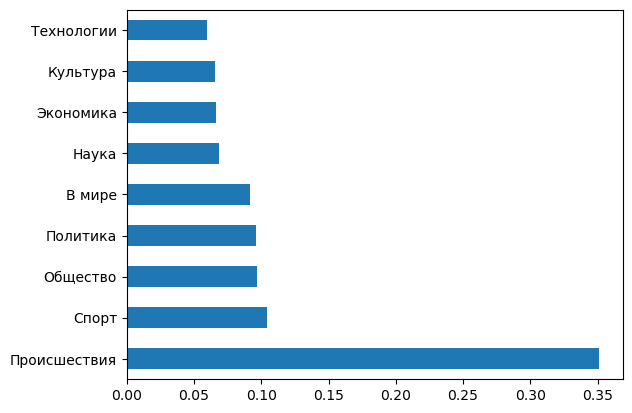

In [17]:
# Горизонтальная столбчатая диаграмма
df1['rubric'].value_counts(normalize=True).plot.barh()

In [24]:
df1['rubric'].value_counts()

Происшествия    640
Спорт           190
Общество        176
Политика        175
В мире          167
Наука           125
Экономика       121
Культура        119
Технологии      109
Name: rubric, dtype: int64

## Предварительная обработка данных (preprocessing). Обработка естественного языка NLP


Действия, выполняемые в процессе:
* сегментация и токенизация;
* стемминг;
* удаление стоп-слов;
* лемматизация.

### Удаление пробельных символов

In [18]:
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df1['text']]
df_nlp = df1.loc[:, ['rubric','title','text']]
df_nlp["text_prep"] = prep_text

#df_nlp.drop(df1.columns[[8]], axis = 1), если получился лишний случайно
#df_nlp

### Стемминг

In [19]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
#nltk.download('punkt')
#nltk.download('stopwords')
#если нет этих модулей

stemmer = SnowballStemmer("russian")
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

stemmed_texts_list = []
for text in df_nlp["text_prep"]:
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)
    
df_nlp["text_stem"] = stemmed_texts_list

def remove_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    return " ".join(tokens)

### Удаление стоп-слов

In [20]:
from nltk import word_tokenize

sw_texts_list = []
for text in df_nlp['text_prep']:
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_nlp["text_sw"] = sw_texts_list
#df_nlp["text_sw"][0]
#df_nlp

### Лемматизация

In [21]:
from pymystem3 import Mystem

mystem = Mystem()
lemm_texts_list = []

text_list = df_nlp['text_sw'].to_list()
text_join = "joining".join(text_list)

try:
    text_lem = mystem.lemmatize(text_join)
    tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
    text = " ".join(tokens)
except Exception as e:
    print(e)

text_split = text.split("joining")
df_nlp["text_lemm"] = text_split

df_nlp

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
0,Политика,Путину доложили о ЧП на военных аэродромах,Официальный представитель Кремля Дмитрий Песко...,официальный представитель кремля дмитрий песко...,официальн представител кремл дмитр песк понеде...,официальный представитель кремля дмитрий песко...,официальный представитель кремль дмитрий песок...
1,Политика,Песков: Путину доложили о происшествиях в Сара...,Пресс-секретарь президента РФ Дмитрий Песков с...,пресс секретарь президента рф дмитрий песков с...,пресс секретар президент рф дмитр песк сообщ п...,пресс секретарь президента рф дмитрий песков с...,пресс секретарь президент рф дмитрий песок соо...
2,Политика,Песков: Путину доложили о происшествиях в Сара...,Официальный представитель Кремля Дмитрий Песко...,официальный представитель кремля дмитрий песко...,официальн представител кремл дмитр песк сообщ ...,официальный представитель кремля дмитрий песко...,официальный представитель кремль дмитрий песок...
3,Политика,Путину доложили о ЧП на аэродроме под Рязанью,Официальный представитель Кремля Дмитрий Песко...,официальный представитель кремля дмитрий песко...,официальн представител кремл дмитр песк понеде...,официальный представитель кремля дмитрий песко...,официальный представитель кремль дмитрий песок...
4,Политика,Президенту России доложили о взрыве на военном...,Пресс-секретарь главы государства Дмитрий Песк...,пресс секретарь главы государства дмитрий песк...,пресс секретар глав государств дмитр песк подт...,пресс секретарь главы государства дмитрий песк...,пресс секретарь глава государство дмитрий песо...
...,...,...,...,...,...,...,...
1817,Наука,Арахис и специи оказались полезными для кишечн...,"Новое исследование показало, что включение в р...",новое исследование показало что включение в ра...,нов исследован показа включен рацион – г арахи...,новое исследование показало включение рацион –...,новое исследование показывать включение рацион...
1818,Наука,Clinical Nutrition: на здоровье кишечника могу...,"Ученые выяснили, что добавление 300 граммов ар...",ученые выяснили что добавление граммов арахиса...,учен выясн добавлен грамм арахис одн чайн ложк...,ученые выяснили добавление граммов арахиса одн...,ученые выяснять добавление грамм арахис чайный...
1819,Наука,"Арахис, травы и специи помогают улучшить микро...","Группа исследователей установила, что арахис, ...",группа исследователей установила что арахис тр...,групп исследовател установ арахис трав спец по...,группа исследователей установила арахис травы ...,группа исследователь устанавливать арахис трав...
1820,Наука,"Ученые назвали популярные продукты, которые мо...","Специалисты заметили, что у перекусывающих ара...",специалисты заметили что у перекусывающих арах...,специалист замет перекусыва арахис люд горазд ...,специалисты заметили перекусывающих арахисом л...,специалисты замечать перекусывать арахис челов...


In [41]:
df_pr = df_nlp.loc[df_nlp['rubric'] == 'Происшествия'].head(200)
df_other = df_nlp.loc[df_nlp['rubric'] != 'Происшествия']

df_ml = pd.concat([df_pr, df_other])
#df_ml

<AxesSubplot:>

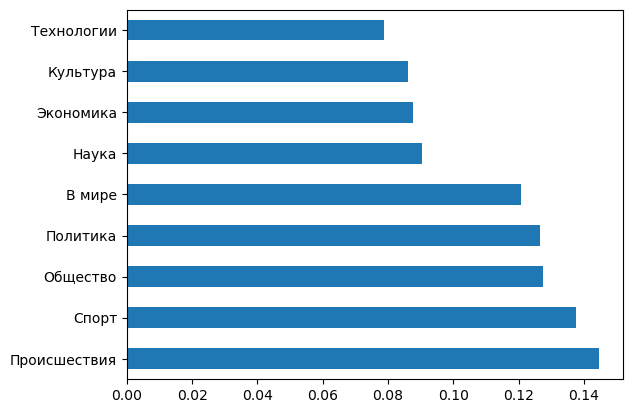

In [42]:
# Горизонтальная столбчатая диаграмма
df_ml['rubric'].value_counts(normalize=True).plot.barh()

## Создание моделей машинного обучения

### Кодирование целевой переменной. Формирование тестовой и обучающей выборок

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)

X = df_ml['text_lemm']
#X = df_nlp['text_sw']
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Байесовский классификатор

In [45]:
from sklearn.naive_bayes import MultinomialNB
nb = Pipeline ([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
               ])

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.7349397590361446
              precision    recall  f1-score   support

    Политика       0.45      0.35      0.39        55
    Общество       1.00      0.63      0.78        41
   Экономика       0.96      0.84      0.90        31
      В мире       0.77      0.71      0.73        51
       Спорт       0.84      0.92      0.88        61
Происшествия       0.46      0.84      0.59        50
    Культура       0.84      0.95      0.89        55
  Технологии       1.00      0.70      0.83        27
       Наука       0.88      0.66      0.75        44

    accuracy                           0.73       415
   macro avg       0.80      0.73      0.75       415
weighted avg       0.77      0.73      0.74       415



### Метод опорных векторов

In [46]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline ([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                ])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.8024096385542169
              precision    recall  f1-score   support

    Политика       0.44      0.35      0.39        55
    Общество       0.95      0.88      0.91        41
   Экономика       0.91      0.94      0.92        31
      В мире       0.91      0.82      0.87        51
       Спорт       0.83      0.90      0.87        61
Происшествия       0.62      0.80      0.70        50
    Культура       0.93      0.96      0.95        55
  Технологии       0.89      0.93      0.91        27
       Наука       0.83      0.77      0.80        44

    accuracy                           0.80       415
   macro avg       0.81      0.82      0.81       415
weighted avg       0.80      0.80      0.80       415



### Логистическая регрессия

In [47]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline ([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                   ])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.7855421686746988
              precision    recall  f1-score   support

    Политика       0.47      0.44      0.45        55
    Общество       0.86      0.93      0.89        41
   Экономика       0.97      0.94      0.95        31
      В мире       0.73      0.80      0.77        51
       Спорт       0.86      0.92      0.89        61
Происшествия       0.64      0.70      0.67        50
    Культура       0.94      0.87      0.91        55
  Технологии       0.86      0.89      0.87        27
       Наука       0.89      0.70      0.78        44

    accuracy                           0.79       415
   macro avg       0.80      0.80      0.80       415
weighted avg       0.79      0.79      0.78       415



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Дерево решений 

In [48]:
from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline ([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', DecisionTreeClassifier(max_depth = 2)),
                   ])

dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.21927710843373494
              precision    recall  f1-score   support

    Политика       0.00      0.00      0.00        55
    Общество       0.00      0.00      0.00        41
   Экономика       0.00      0.00      0.00        31
      В мире       0.14      1.00      0.24        51
       Спорт       0.00      0.00      0.00        61
Происшествия       1.00      0.38      0.55        50
    Культура       1.00      0.38      0.55        55
  Технологии       0.00      0.00      0.00        27
       Наука       0.00      0.00      0.00        44

    accuracy                           0.22       415
   macro avg       0.24      0.20      0.15       415
weighted avg       0.27      0.22      0.17       415



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Метод K ближайщих соседей KNN

#### Для n_neighbors=3

In [62]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3)),
               ])

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.7879518072289157
              precision    recall  f1-score   support

    Политика       0.46      0.49      0.47        55
    Общество       0.93      0.90      0.91        41
   Экономика       0.77      0.87      0.82        31
      В мире       0.86      0.84      0.85        51
       Спорт       0.86      0.79      0.82        61
Происшествия       0.64      0.74      0.69        50
    Культура       0.94      0.89      0.92        55
  Технологии       0.96      0.85      0.90        27
       Наука       0.88      0.82      0.85        44

    accuracy                           0.79       415
   macro avg       0.81      0.80      0.80       415
weighted avg       0.80      0.79      0.79       415



#### Для n_neighbors=9

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=9)),
               ])

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.7542168674698795
              precision    recall  f1-score   support

    Политика       0.46      0.47      0.46        55
    Общество       0.92      0.88      0.90        41
   Экономика       0.83      0.77      0.80        31
      В мире       0.77      0.71      0.73        51
       Спорт       0.82      0.82      0.82        61
Происшествия       0.62      0.78      0.69        50
    Культура       0.90      0.85      0.88        55
  Технологии       0.87      0.74      0.80        27
       Наука       0.80      0.80      0.80        44

    accuracy                           0.75       415
   macro avg       0.78      0.76      0.76       415
weighted avg       0.76      0.75      0.76       415



### Метод градиентного бустинга

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingRegressor(n_estimators=200, max_depth=12, criterion='squared_error', learning_rate=0.03, min_samples_leaf=16, min_samples_split=16)),
               ])

In [57]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 2.15 s, sys: 12 ms, total: 2.17 s
Wall time: 2.17 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingRegressor(criterion='squared_error',
                                           learning_rate=0.03, max_depth=12,
                                           min_samples_leaf=16,
                                           min_samples_split=16,
                                           n_estimators=200))])

In [58]:
%%time
y_pred = gbr.predict(X_test)

CPU times: user 17.7 ms, sys: 2.16 ms, total: 19.9 ms
Wall time: 18.3 ms


In [61]:
from sklearn.metrics import mean_squared_error,r2_score 

train_accuracy_score=gbr.score(X_train,y_train)
test_accuracy_score=gbr.score(X_test,y_test)
mse = mean_squared_error(y_test,y_pred)

print(train_accuracy_score)
print(test_accuracy_score)
print("MSE: %.2f" % mse)
print(r2_score(y_test,y_pred))

0.38607753283743684
0.17644462561204666
MSE: 5.23
0.17644462561204666
